#### In this notebook, I will train a conditional flow to add RA and Dec, and I will use the LSST Error Model to add errors.

In [1]:
import numpy as onp
import jax.numpy as np
import matplotlib.pyplot as plt
import corner
import pandas as pd

import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, ColorTransform, InvSoftplus, StandardScaler, RollingSplineCoupling
from pzflow.distributions import Uniform

In [2]:
# plotting style
plt.style.use('../paper.mplstyle')
twocol = 7.1014
onecol = 3.35

#### Load the DC2 Data

In [3]:
data = pd.read_pickle("dc2.pkl")
# select a subset
data = data.iloc[:1000000]
# print some of the data
data

,ra,dec,redshift,u,g,r,i,z,y
0,54.711133,-37.129134,2.008235,27.136230,26.670242,26.667273,26.582212,26.357750,26.152222
1,57.596370,-44.416915,0.978697,27.316854,27.212221,26.671032,25.900785,25.353924,25.256409
2,67.631866,-35.667108,1.141199,27.646139,27.523197,27.239439,26.955040,26.153460,26.039215
3,61.183022,-29.018957,0.380182,30.007523,28.263083,26.901390,26.366058,26.075935,25.875998
4,71.067002,-29.777124,1.215204,25.069988,25.117722,25.167130,25.186823,24.732811,24.613487
...,...,...,...,...,...,...,...,...,...
999995,64.520258,-27.058435,2.395404,28.358000,27.508904,27.257092,27.326817,27.170570,27.028576
999996,51.398371,-38.874837,0.915248,25.462215,25.123844,24.359940,23.329554,22.892763,22.825127
999997,54.454384,-35.611503,1.398047,27.489780,27.503931,27.583220,27.555323,27.463623,26.960890
999998,58.807813,-36.703714,1.299518,26.708790,26.492617,26.126745,25.646049,25.030140,24.421446


#### Create a conditional flow to model RA and Dec as a function of redshift and colors

Note that because the RA and Dec in this set are fairly concentrated on the sky, I won't use circular splines, but since the RA and Dec have sharp cutoffs, I will use uniform distributions.

In [4]:
# pick means and stds so that each has domain (-3, 3)
means = data[["ra", "dec"]].mean().values
stds = np.abs((data[["ra", "dec"]].max().values - means)/3)

# construct our bijector
bijector = Chain(
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers=2, n_conditions=7),
)

latent = Uniform((-3, 3), (-3, 3))

cflow = Flow(data.columns[:2], bijector, latent=latent,
                 conditional_columns=data.columns[2:])

We should standard scale the conditional columns before interaction with the flow. Let's create a function to do this for us

In [5]:
conditional_columns = data.columns[2:]
M = data[conditional_columns].mean()
S = data[conditional_columns].std()
def condition_scaler(data):
    scaled_data = data.copy()
    scaled_data[conditional_columns] = (data[conditional_columns] - M) / S
    return scaled_data

#### Train the flow

In [6]:
%%time
losses = cflow.train(condition_scaler(data), epochs=100, verbose=True)

Training 100 epochs 
Loss:
6.2665
5.9506
5.9364
5.9325
5.9301
5.9231
5.9143
5.9084
5.9010
5.8950
5.8942
5.8909
5.8845
5.8813
5.8809
5.8779
5.8729
5.8787
5.8760
5.8622
5.8624
CPU times: user 12min 21s, sys: 6min 26s, total: 18min 48s
Wall time: 8min 33s


#### Plot the results

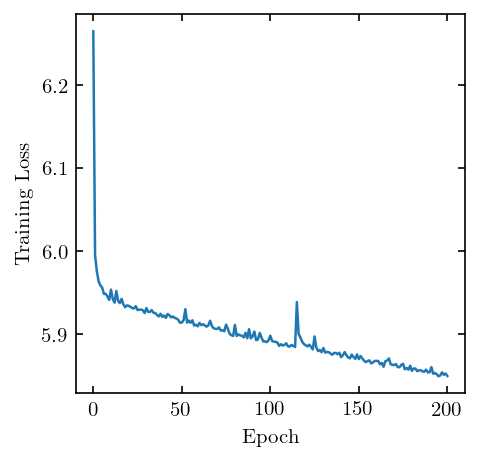

In [7]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

In [8]:
samples = cflow.sample(1, conditions=condition_scaler(data[:10000]), seed=0)
samples[conditional_columns] = data[conditional_columns]

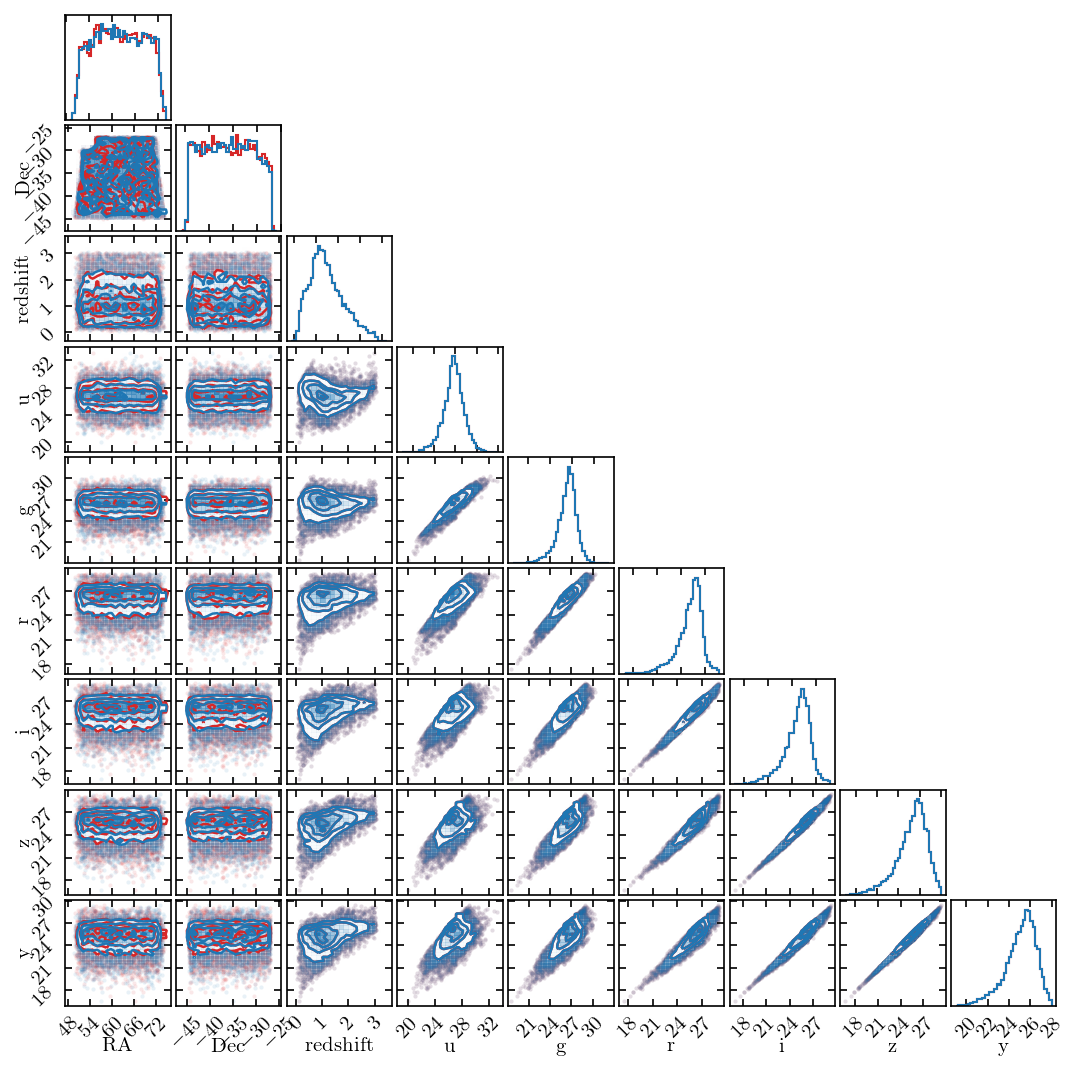

In [9]:
fig = plt.figure(figsize=(twocol, twocol))

ranges = [(49,74), (-46,-26), (-0.1,3.4), (19.5,33), (19,32), (19,29), (19,29), (19,28), (19,28)]

corner.corner(samples, fig=fig, color='C3', bins=20, range=ranges, hist_bin_factor=2, data_kwargs={'ms':2})

corner.corner(data[:10000], fig=fig, bins=20, range=ranges, hist_bin_factor=2, color='C0',
              labels=["RA", "Dec", "redshift", "u", "g", "r", "i", "z", "y"]);

In [10]:
cflow.info = {
    "description": 
"""
Conditional flow for the forward model section of the pzflow paper.
Trained on 100,000 galaxies from DESC DC2 DR6.
Models p(RA, Dec | redshift, magnitudes).

This flow was created with pzflow version {pzflow.__version__}
""",
    "condition_scaler": condition_scaler,
}

In [11]:
cflow.save("desc-dc2-dr6-conditional-position-flow.pkl")